In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])
trainset = datasets.MNIST('PATH_TO_STORE_DATASET', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [7]:
def conv3d(input_tensor, weight, bias=None, stride=1, padding=0, activation='relu'):
    output = F.conv3d(input_tensor, weight, bias, stride=stride, padding=padding)
    if activation == 'relu':
        return F.relu(output)
    elif activation == 'sigmoid':
        return torch.sigmoid(output)
    elif activation == 'tanh':
        return torch.tanh(output)
    elif activation == 'leaky_relu':
        return F.leaky_relu(output)
    else:
        return output

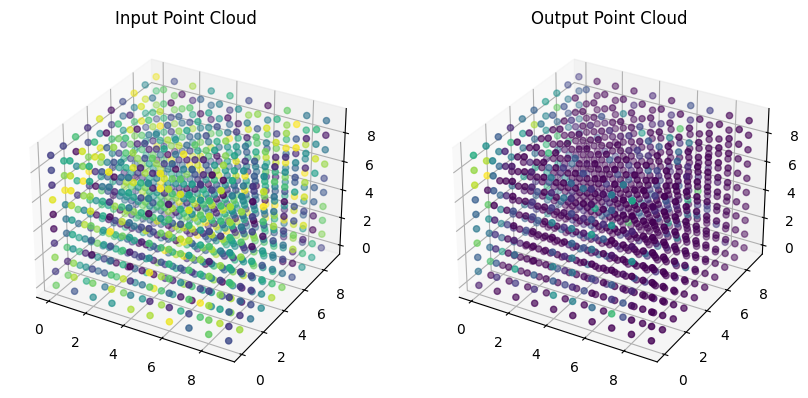

In [27]:
point_cloud = np.random.rand(1, 1, 10, 10, 10)  # Example: 1 batch, 1 channel, 10x10x10 points
point_cloud_tensor = torch.tensor(point_cloud, dtype=torch.float32)

# Define a 3D convolutional kernel (replace with your desired kernel)
kernel_size = 3
kernel = torch.randn(1, 1, kernel_size, kernel_size, kernel_size, requires_grad=True)

# Apply the 3D convolution
output = conv3d(point_cloud_tensor, kernel, padding=1)  # Example with padding

# Plot a single slice of the input and output point cloud
# Input point cloud
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121, projection='3d')
x,y,z = np.indices(point_cloud.shape[2:])
ax1.scatter(x,y,z, c=point_cloud[0,0])
ax1.set_title('Input Point Cloud')

# Output point cloud
ax2 = fig.add_subplot(122, projection='3d')
x,y,z = np.indices(output.detach().numpy().shape[2:])
ax2.scatter(x,y,z, c=output.detach().numpy()[0,0])
ax2.set_title('Output Point Cloud')
plt.show()


In [28]:
# prompt: show expected output shape for above plots
print("Input Point Cloud Shape:", point_cloud.shape)
print("Output Point Cloud Shape:", output.shape)

Input Point Cloud Shape: (1, 1, 10, 10, 10)
Output Point Cloud Shape: torch.Size([1, 1, 10, 10, 10])


In [8]:
# 2. 3D Pooling Function
def pool3d(input_tensor, kernel_size=2, stride=2, pooling_type='max'):
    if pooling_type == 'max':
        return F.max_pool3d(input_tensor, kernel_size, stride)
    elif pooling_type == 'avg':
        return F.avg_pool3d(input_tensor, kernel_size, stride)

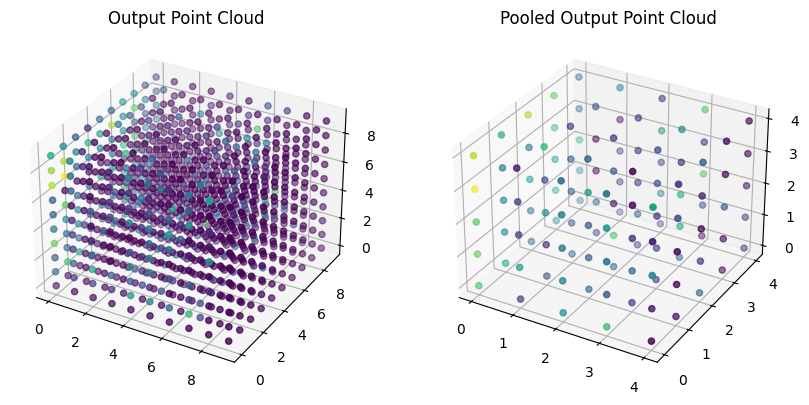

Pooled Output Shape: torch.Size([1, 1, 5, 5, 5])


In [29]:
pooled_output = pool3d(output, kernel_size=2, stride=2)

# Plot a single slice of the pooled output
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
x, y, z = np.indices(output.detach().numpy().shape[2:])
ax1.scatter(x,y,z, c=output.detach().numpy()[0,0])
ax1.set_title('Output Point Cloud')

ax2 = fig.add_subplot(122, projection='3d')
x, y, z = np.indices(pooled_output.detach().numpy().shape[2:])
ax2.scatter(x, y, z, c=pooled_output.detach().numpy()[0, 0])
ax2.set_title('Pooled Output Point Cloud')
plt.show()

print("Pooled Output Shape:", pooled_output.shape)


In [9]:
# 3. 3D Convolution Layer Function
class Conv3DLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, activation='relu'):
        super(Conv3DLayer, self).__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.activation = activation

    def forward(self, x):
        x = self.conv(x)
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x)
        return x

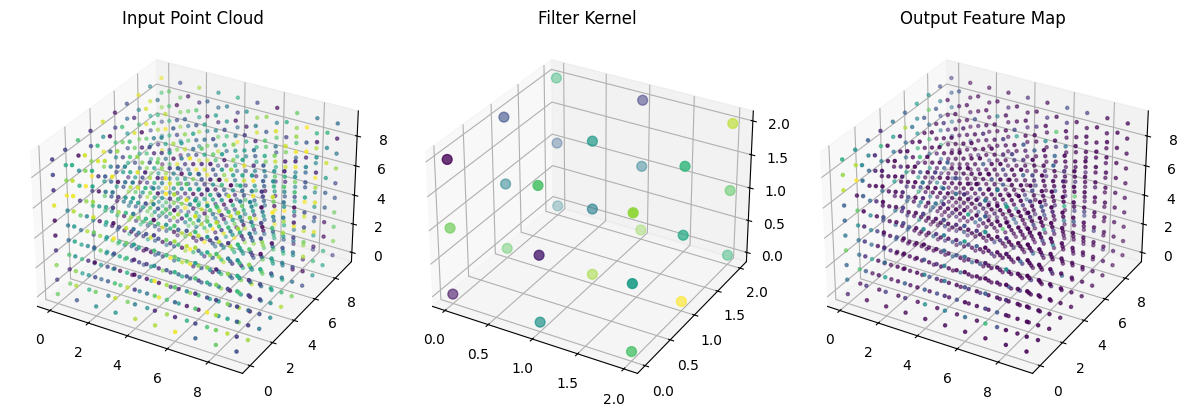

Input Point Cloud Shape: (1, 1, 10, 10, 10)
Kernel Shape: torch.Size([1, 1, 3, 3, 3])
Output Feature Map Shape: torch.Size([1, 1, 10, 10, 10])


In [30]:
# Display the input point cloud
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(131, projection='3d')
x, y, z = np.indices(point_cloud.shape[2:])
ax.scatter(x, y, z, c=point_cloud[0, 0], s=5)  # Reduced marker size for better visualization
ax.set_title('Input Point Cloud')

# Display the filter kernel (assuming a 3x3x3 kernel for visualization)
kernel_np = kernel.detach().numpy().squeeze()
ax = fig.add_subplot(132, projection='3d')
x, y, z = np.indices(kernel_np.shape)
ax.scatter(x, y, z, c=kernel_np, s=50)
ax.set_title('Filter Kernel')

# Display the output feature map
ax = fig.add_subplot(133, projection='3d')
output_np = output.detach().numpy().squeeze()
x, y, z = np.indices(output_np.shape)
ax.scatter(x, y, z, c=output_np, s=5) # Reduced marker size
ax.set_title('Output Feature Map')

plt.tight_layout()
plt.show()

print("Input Point Cloud Shape:", point_cloud.shape)
print("Kernel Shape:", kernel.shape)
print("Output Feature Map Shape:", output.shape)


In [35]:
class Pool3DLayer(nn.Module):
    def __init__(self, kernel_size, stride, pooling_type='max', global_pool=False):
        super(Pool3DLayer, self).__init__()
        self.global_pool = global_pool
        self.pooling_type = pooling_type
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        if self.global_pool:
            return F.adaptive_avg_pool3d(x, 1).view(x.size(0), -1)
        if self.pooling_type == 'max':
            # Adjust padding to ensure valid output size
            padding = (self.kernel_size - 1) // 2
            # Adjust kernel_size or stride for the depth dimension to avoid 0 output size
            kernel_size_depth = min(self.kernel_size, x.shape[-1])
            stride_depth = min(self.stride, x.shape[-1])
            # Apply max pooling with adjusted parameters
            return F.max_pool3d(x, (self.kernel_size, self.kernel_size, kernel_size_depth),
                                 (self.stride, self.stride, stride_depth), padding=padding)
        else:
            return F.avg_pool3d(x, self.kernel_size, self.stride)

In [10]:
# 4. 3D Pooling Layer Function
class Pool3DLayer(nn.Module):
    def __init__(self, kernel_size, stride, pooling_type='max', global_pool=False):
        super(Pool3DLayer, self).__init__()
        self.global_pool = global_pool
        self.pooling_type = pooling_type
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        if self.global_pool:
            return F.adaptive_avg_pool3d(x, 1).view(x.size(0), -1)
        if self.pooling_type == 'max':
            return F.max_pool3d(x, self.kernel_size, self.stride)
        else:
            return F.avg_pool3d(x, self.kernel_size, self.stride)

MAX Pooling:
Input Shape: torch.Size([1, 1, 10, 10, 10])
Output Shape: torch.Size([1, 1, 5, 5, 5])


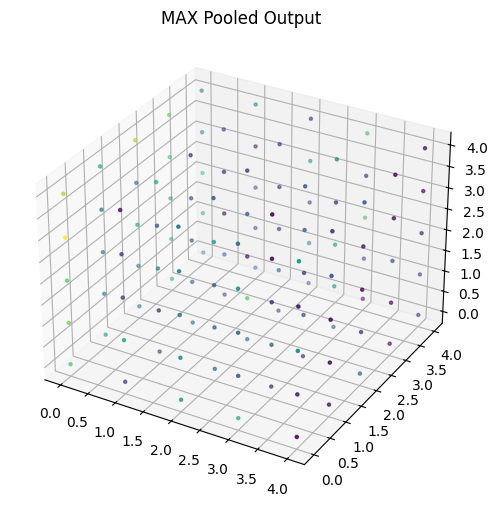

AVG Pooling:
Input Shape: torch.Size([1, 1, 10, 10, 10])
Output Shape: torch.Size([1, 1, 5, 5, 5])


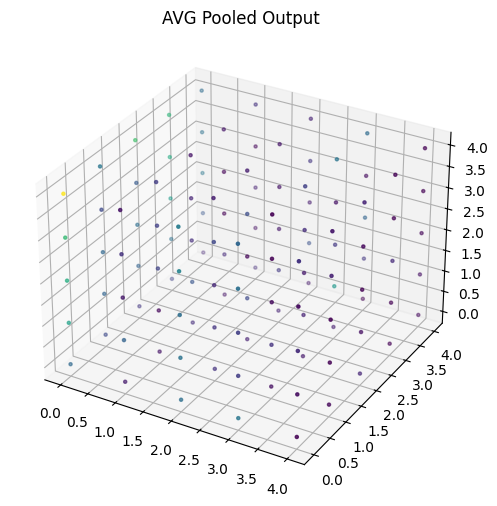

In [31]:
def verify_pooling(input_tensor, kernel_size=2, stride=2, pooling_types=['max', 'avg']):
    results = {}
    for pooling_type in pooling_types:
        pooled_output = pool3d(input_tensor, kernel_size, stride, pooling_type)
        results[pooling_type] = pooled_output

        print(f"{pooling_type.upper()} Pooling:")
        print("Input Shape:", input_tensor.shape)
        print("Output Shape:", pooled_output.shape)

        # Visualization (Optional)
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')
        x, y, z = np.indices(pooled_output.detach().numpy().shape[2:])
        ax.scatter(x, y, z, c=pooled_output.detach().numpy()[0, 0], s=5)  # Reduced marker size
        ax.set_title(f'{pooling_type.upper()} Pooled Output')
        plt.show()

    return results

# Example usage:
pooled_results = verify_pooling(output)


In [11]:
# 5. MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [12]:
# 6. Complete 3D CNN Model
class Complete3DCNN(nn.Module):
    def __init__(self):
        super(Complete3DCNN, self).__init__()
        self.layer1 = Conv3DLayer(1, 16, kernel_size=5, stride=1, padding=2, activation='relu')
        self.pool1 = Pool3DLayer(kernel_size=2, stride=2, pooling_type='max')
        self.layer2 = Conv3DLayer(16, 32, kernel_size=3, stride=1, padding=1, activation='relu')
        self.pool2 = Pool3DLayer(kernel_size=2, stride=2, pooling_type='max')
        self.gap = Pool3DLayer(kernel_size=1, stride=1, global_pool=True)
        self.mlp = MLPClassifier(32, 64, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.pool2(x)
        x = self.gap(x)
        x = self.mlp(x)
        return x

In [ ]:
def reshape_mnist_data(data):
    return data.view(-1, 1, 28, 28, 1)  # channels, depth, height, width

# Instantiate the model
model = Complete3DCNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5 # Keep it small for demonstration
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = reshape_mnist_data(inputs)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 200 == 199:  # Print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 2.233
[1,   400] loss: 2.118
[1,   600] loss: 2.041
[1,   800] loss: 1.976
[2,   200] loss: 1.903
[2,   400] loss: 1.868
[2,   600] loss: 1.854
[2,   800] loss: 1.830
[3,   200] loss: 1.801
[3,   400] loss: 1.783
[3,   600] loss: 1.772


In [13]:
def count_balanced_parentheses(sequence):
    stack = []
    pairs = {'(': ')', '{': '}', '[': ']', '<': '>'}
    count = 0
    for char in sequence:
        if char in pairs:
            stack.append(char)
        elif char in pairs.values():
            if stack and pairs[stack[-1]] == char:
                stack.pop()
                count += 1
    return count

In [ ]:
# prompt: create dataset of parenthesis and save it

import pandas as pd
import random

def generate_parenthesis_data(num_samples, max_length):
    data = []
    for _ in range(num_samples):
        length = random.randint(1, max_length)
        sequence = ""
        for _ in range(length):
            sequence += random.choice("(){}[]<>")
        balanced_count = count_balanced_parentheses(sequence)
        data.append([sequence, balanced_count])
    return pd.DataFrame(data, columns=['sequence', 'balanced_count'])

def count_balanced_parentheses(sequence):
    stack = []
    pairs = {'(': ')', '{': '}', '[': ']', '<': '>'}
    count = 0
    for char in sequence:
        if char in pairs:
            stack.append(char)
        elif char in pairs.values():
            if stack and pairs[stack[-1]] == char:
                stack.pop()
                count += 1
    return count

# Generate the dataset
dataset = generate_parenthesis_data(1000, 20) # Example: 1000 samples, max length 20

# Save the dataset to a CSV file
dataset.to_csv('parenthesis_dataset.csv', index=False)


In [14]:
class ElmanNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanNet, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# LSTM Network
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [16]:
# GRU Network
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out